# Imports

In [2]:
# pip install pandas_datareader

     ---------------------------------------- 0.0/109.5 kB ? eta -:--:--
     ----------------------------------- -- 102.4/109.5 kB 3.0 MB/s eta 0:00:01
     -------------------------------------- 109.5/109.5 kB 2.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import kurtosis, skew
from scipy.stats import norm
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader as dr

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[15, 6]
import matplotlib.cm as cm

# Helper Functions

In [4]:
def performance_summary(return_data):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*12)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(12))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.5)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.5)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [5]:
def regression_based_performance(factor,fund_ret,rf,constant = True):
    """ 
        Returns the Regression based performance Stats for given set of returns and factors
        Inputs:
            factor - Dataframe containing monthly returns of the regressors
            fund_ret - Dataframe containing monthly excess returns of the regressand fund
            rf - Monthly risk free rate of return
        Output:
            summary_stats - (Beta of regression, treynor ratio, information ratio, alpha). 
    """
    if constant:
        X = sm.tools.add_constant(factor)
    else:
        X = factor
    y=fund_ret
    model = sm.OLS(y,X,missing='drop').fit()
    
    if constant:
        beta = model.params[1:]
        alpha = round(float(model.params['const']),6) *12

        
    else:
        beta = model.params
    treynor_ratio = ((fund_ret - rf).mean()*12)/beta[0]
    tracking_error = (model.resid.std()*np.sqrt(12))
    if constant:        
        information_ratio = model.params[0]*12/tracking_error
    r_squared = model.rsquared
    if constant:
        return (beta,treynor_ratio,information_ratio,alpha,r_squared,tracking_error,model.resid)
    else:
        return (beta,treynor_ratio,r_squared,tracking_error,model.resid)

In [7]:
def tangency_portfolio_rfr(asset_return,cov_matrix):
    """ 
        Returns the tangency portfolio weights in a (1 x n) vector when a riskless assset is available
        Inputs: 
            asset_return - Excess return over the risk free rate for each asset (n x 1) Vector
            cov_matrix = nxn covariance matrix for the assets
    """
    asset_cov = np.array(cov_matrix)
    inverted_cov= np.linalg.inv(asset_cov)
    one_vector = np.ones(len(cov_matrix.index))
    
    den = (one_vector @ inverted_cov) @ (asset_return)
    num =  inverted_cov @ asset_return
    return (1/den) * num

# Reading Data

In [9]:
ff_factors = pd.read_excel(r'momentum_data.xlsx',sheet_name = 'factors (excess returns)')
ff_factors = ff_factors.set_index('Date')

In [10]:
size_ports = pd.read_excel(r'momentum_data.xlsx',sheet_name = 'size_sorts (total returns)')
size_ports = size_ports.set_index('Date')

In [11]:
rf = pd.read_excel(r'momentum_data.xlsx',sheet_name = 'risk-free rate')
rf = rf.set_index('Date')

In [12]:
mom_deciles = pd.read_excel(r'momentum_data.xlsx',sheet_name = 'deciles (total returns)')
mom_deciles = mom_deciles.set_index('Date')

In [13]:
momentum = pd.read_excel(r'momentum_data.xlsx',sheet_name = 'momentum (excess returns)')
momentum = momentum.set_index('Date')

ff_factors['UMD'] = momentum['UMD']

## 2) Investigating Momentum

#### In this section, we empirically investigate some concerns regarding AQR’s new momentum product.

#### On GitHub, find the data file, “momentum data.xlsx”.


- #### The third tab contains the momentum factor as an excess return: $\tilde{r}^{mom}$


- #### The fourth tab contains returns on portfolios corresponding to scored momentum deciles.
    - #### $\tilde{r}^{mom(1)}$ denotes the portfolio of stocks in the lowest momentum decile, the “losers” with the lowest past returns.
    - #### $\tilde{r}^{mom(10)}$ denotes the portfolio of stocks in the highest momentum decile.


- #### The fifth tab gives portfolios sorted by momentum and size.
    - #### $\tilde{r}^{momSU}$ denotes the portfolio of small stocks in the top 3 deciles of momentum scores.
    - #### $\tilde{r}^{momBD}$ denotes the portfolio of big-stocks in the bottom 3 deciles of momentum scores.


#### Note that the Fama-French momentum return, $\tilde{r}^{mom:FF}$, given in the third tab, is constructed by FF as,


#### $$\tilde{r}^{mom:FF} = \frac{1}{2} (\tilde{r}^{momBU} + \tilde{r}^{momSU}) − \frac{1}{2} (\tilde{r}^{momBD} + \tilde{r}^{momSD}) $$

### 2.1.a) Is momentum still profitable?

The excess returns of lucrative trading strategies often disappear once the strategy is well-known. The first widely-cited paper on momentum was published in 1993. Have momentum returns or risk changed since then? The AQR case takes place at the end of 2008. Have momentum returns changed in 2009-2023?


Investigate by filling out the summary statistics below for the full-sample and three sub-samples.

(a) Using the data provided, fill in Table 1 with the appropriate stats for $\tilde{r}^{mom:FF}$

|<caption>Table 1: Momentum performance over time.</caption>|Subsample|mean|vol|Sharpe|Skewness|corr. to $\tilde{r}^m$|corr. to $\tilde{r}^v$|
|------------------------:|------------------------:|-----------------------:|------------------------:|-----------------------:|------------------------:|-----------------------:|-----------------------:|
|1927 - 2023|||||||||
|1927 - 1993|||||||||
|1994 - 2008|||||||||
|2009 - 2023|||||||||


In [15]:
sub_samples = {
              '1927-2023' : ['1927','2023'],
              '1927-1993' : ['1927','1993'],
              '1994-2008' : ['1994','2008'],
              '2009-2023' : ['2009','2023']
              }

mom_sum = []
for k,v in sub_samples.items():
    sub_mom = momentum.loc[sub_samples[k][0]:sub_samples[k][1]]
    sub_ff = ff_factors.loc[sub_samples[k][0]:sub_samples[k][1]]
    mom_summary = performance_summary(sub_mom)
    mom_summary = mom_summary.loc[:,['Mean','Volatility','Sharpe Ratio','Skewness']]
    mom_summary['Corr Mkt'] = sub_ff.corr().loc['MKT',['UMD']]
    mom_summary['Corr Val'] = sub_ff.corr().loc['HML',['UMD']]
    mom_summary.index = [k]
    mom_sum.append(mom_summary)

mom_summary = pd.concat(mom_sum)
mom_summary

,Mean,Volatility,Sharpe Ratio,Skewness,Corr Mkt,Corr Val
1927-2023,0.074791,0.163069,0.458647,-2.992077,-0.346337,-0.404836
1927-1993,0.090113,0.159991,0.563242,-3.808977,-0.362537,-0.494960
1994-2008,0.104373,0.175551,0.594548,-0.582038,-0.234519,-0.129402
2009-2023,-0.026030,0.161623,-0.161052,-2.698287,-0.385511,-0.309380


### 2.1.b) Has momentum changed much over time, as seen through these subsample statistics?

- Before 2009, the momentum strategy posted significant positive returns. After the AQR case, the momentum strategy turned negtaive annual returns and negative Sharpe ratio from 2009 to 2023. This might be the result of making the strategy well-known, financial crisis, and Covid crisis.

### 2.1.c) Does this data support AQR's argument that momentum is an important piece of the ideal portfolio? What if mean returns to momentum are in actuality near zero due to transaction costs - would there still be evidence here that momentum is valuable?

- If the post-fee return is nearly 0%, the momentum factor might not contribute additional excess return to the portfolio. However, throughout all the periods, the momentum strategy displays negative correlations with Market factor and Value factor, making it still an worthy factor in terms of diversification and shifting the efficient frontier.

### 2.2) The case is about whether a long-only implementation of momentum is valuable.

#### Construct your own long-only implementation:

#### $$\tilde{r}^{momU:FF} = \frac{1}{2} (\tilde{r}^{momBU} + \tilde{r}^{momSU}) − r^f $$

#### Note that this is following the FF approach of treating big and small stocks separately. This would be very similar to a scaled version of,

#### $$\tilde{r}^{momU} = \frac{1}{3} (\tilde{r}^{mom(8)} + \tilde{r}^{mom(9)} + \tilde{r}^{mom(10)}) − r^f $$


#### For the question below, use the FF-style $\tilde{r}^{momU:FF}_t$


### 2.2.a) Fill out Table 2 for the data in the period 1994-2023.


|<caption>Table 2: Long-only momentum performance.</caption>|1994-2023|mean|vol|Sharpe|Skewness|corr. to $\tilde{r}^m$|corr. to $\tilde{r}^v$|
|------------------------:|-----------------------:|------------------------:|-----------------------:|------------------------:|-----------------------:|-----------------------:|-----------------------:|
|Long-and-short, $\tilde{r}^{mom:FF}$|||||||||
|Long only, $\tilde{r}^{momU:FF}$|||||||||


In [16]:
mom_rtn_long = pd.DataFrame(((1/2*(size_ports['BIG HiPRIOR'] + size_ports['SMALL HiPRIOR']))-rf['RF']),columns = ['UMD'])

ff_long = ff_factors.copy()
ff_long['UMD'] = mom_rtn_long['UMD']
mom_rtn_long_summary = performance_summary(mom_rtn_long['1994':])
mom_rtn_long_summary = mom_rtn_long_summary.loc[:,['Mean','Volatility','Sharpe Ratio','Skewness']]
mom_rtn_long_summary['Corr Mkt'] = ff_long.loc['1994':].corr().loc['MKT',['UMD']]
mom_rtn_long_summary['Corr Val'] = ff_long.loc['1994':].corr().loc['HML',['UMD']]
mom_rtn_long_summary.index = ['Long Only']



In [17]:
mom_rtn_long_short = pd.DataFrame((1/2*((size_ports['BIG HiPRIOR'] + size_ports['SMALL HiPRIOR']) 
                              - (size_ports['BIG LoPRIOR'] + size_ports['SMALL LoPRIOR']))),columns = ['UMD'])
ff_long_short = ff_factors.copy()
ff_long_short['UMD'] = mom_rtn_long_short['UMD']
mom_rtn_long_short_summary = performance_summary(mom_rtn_long_short['1994':])
mom_rtn_long_short_summary = mom_rtn_long_short_summary.loc[:,['Mean','Volatility','Sharpe Ratio','Skewness']]
mom_rtn_long_short_summary['Corr Mkt'] = ff_long_short.loc['1994':].corr().loc['MKT',['UMD']]
mom_rtn_long_short_summary['Corr Val'] = ff_long_short.loc['1994':].corr().loc['HML',['UMD']]
mom_rtn_long_short_summary.index = ['Long and Short']

In [18]:

pdList = [mom_rtn_long_short_summary,mom_rtn_long_summary]
mom_comparison = pd.concat(pdList)
mom_comparison

,Mean,Volatility,Sharpe Ratio,Skewness,Corr Mkt,Corr Val
Long and Short,0.040078,0.169639,0.236256,-1.437502,-0.313551,-0.206171
Long Only,0.115447,0.178350,0.647306,-0.463528,0.901697,-0.130850


### 2.2.b) Is long-only momentum as attractive as long-short momentum with respect to mean, volatility, and Sharpe Ratio?

- The long-only momentum strategy is more attractive than long-short momentum in terms of higher return, Sharpe ratio, and similar volatility.

### 2.2.c) Is long-only momentum as diversifying as long-short momentum with respect to market and value premia?

- The long-only momentum has higher correlation with the market factor (higher than 0.9). So long-only momentum is less diversifiying comparing to the long-short momentum.

### 2.2.d) Show a plot of the cumulative product of 1 + $\tilde{r}^{mom:FF}$ and 1 + $\tilde{r}^{momU:FF}$  over the 1994-2023 subsample.

<Axes: xlabel='Date'>

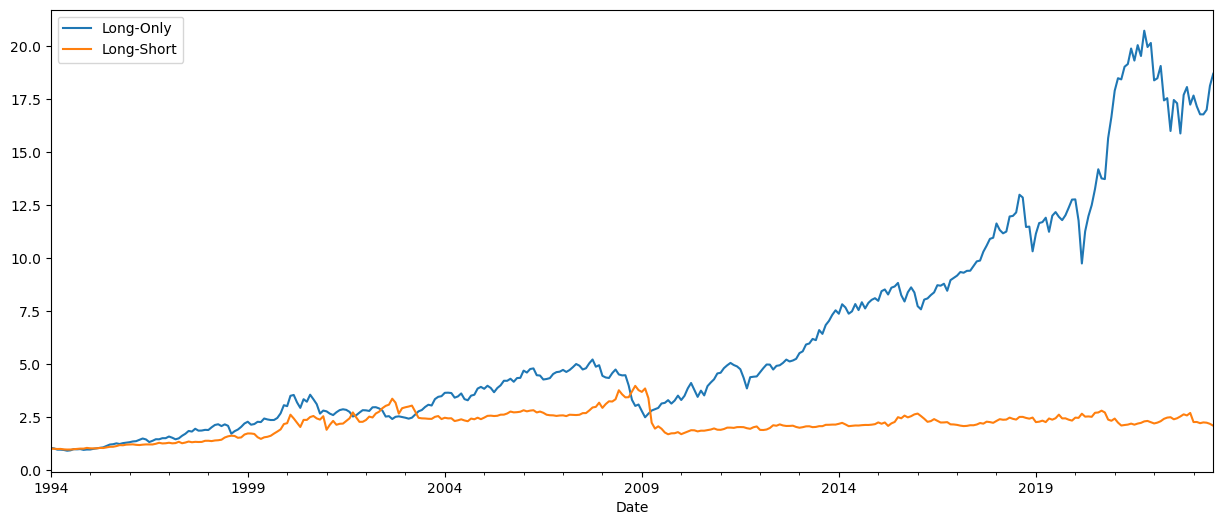

In [24]:
mom_plot = pd.DataFrame(((1/2*(size_ports['BIG HiPRIOR'] + size_ports['SMALL HiPRIOR']))-rf['RF']),columns = ['Long-Only'])
mom_plot['Long-Short'] = 0.5*((size_ports['BIG HiPRIOR'] + size_ports['SMALL HiPRIOR']) 
                              - (size_ports['BIG LoPRIOR'] + size_ports['SMALL LoPRIOR']))
(1+mom_plot['1994':]).cumprod().plot()

### 3) Is momentum just data mining, or is it a robust strategy?

#### Assess how sensitive the threshold for the “winners” and “losers” is in the results. Specifically, we compare three constructions:


- #### long the top 1 decile and short the bottom 1 deciles:

#### $$ \tilde{r}^{momD1} = r^{mom(10)} - r^{mom(1)}$$


- #### long the top 3 deciles and short the bottom 3 deciles:


#### $$ \tilde{r}^{momD3} = \frac{1}{3}(r^{mom(8)} + r^{mom(9)} + r^{mom(10)}) - \frac{1}{3} (r^{mom(3)} + r^{mom(2)} + r^{mom(1)}) $$

#### $$ \tilde{r}^{momD3} = \frac{1}{3}\sum_{k = 8}^{10} r^{mom(k)} - \frac{1}{3}\sum_{k = 1}^{3} r^{mom(k)} $$


- #### long the top 5 deciles and short the bottom 5 decile:

#### $$ \tilde{r}^{momD5} = \frac{1}{5}\sum_{k = 6}^{10} r^{mom(k)} - \frac{1}{5}\sum_{k = 1}^{5} r^{mom(k)} $$

In [25]:
mom_top1_decile = pd.DataFrame(mom_deciles['Hi PRIOR'] - mom_deciles['Lo PRIOR'],columns = ['UMD'])
mom_top3_decile = pd.DataFrame(1/3*((mom_deciles.loc[:,['PRIOR 8','PRIOR 9','Hi PRIOR']].sum(axis = 1))
                                    - (mom_deciles.loc[:,['Lo PRIOR','PRIOR 2','PRIOR 3']].sum(axis = 1))),columns = ['UMD'])

mom_top5_decile = pd.DataFrame(1/5*((mom_deciles.loc[:,['PRIOR 6','PRIOR 7','PRIOR 8','PRIOR 9','Hi PRIOR']].sum(axis = 1))
                                    - (mom_deciles.loc[:,['Lo PRIOR','PRIOR 2','PRIOR 3','PRIOR 4','PRIOR 5']].sum(axis = 1))),columns = ['UMD'])


### 2.3.a) Compare all three constructions, (in the full-sample period,) by filling out the stats in the table below for the period 1994-2023.

|<caption>Table 3: Robustness of momentum construction.</caption>|1994-2023|mean|vol|Sharpe|Skewness|corr. to $\tilde{r}^m$|corr. to $\tilde{r}^v$|
|------------------------:|-----------------------:|------------------------:|-----------------------:|------------------------:|-----------------------:|-----------------------:|-----------------------:|
|$\tilde{r}^{momD1}$|||||||||
|$\tilde{r}^{momD3}$|||||||||
|$\tilde{r}^{momD5}$|||||||||

In [27]:
samples = {'Momentum Top 1 Decile':mom_top1_decile
          ,'Momentum Top 3 Decile':mom_top3_decile
          ,'Momentum Top 5 Decile':mom_top5_decile}

mom_deciles = []
for k,v in samples.items():
    ff = ff_factors.copy()
    ff['UMD'] = v['UMD']
    mom_decile_summary = performance_summary(v['1994':])
    mom_decile_summary = mom_decile_summary.loc[:,['Mean','Volatility','Sharpe Ratio','Skewness']]
    mom_decile_summary['Corr Mkt'] = ff.loc['1994':'2023'].corr().loc['MKT',['UMD']]
    mom_decile_summary['Corr Val'] = ff.loc['1994':'2023'].corr().loc['HML',['UMD']]
    mom_decile_summary.index = [k]
    mom_deciles.append(mom_decile_summary)

mom_deciles_df = pd.concat(mom_deciles)
mom_deciles_df

,Mean,Volatility,Sharpe Ratio,Skewness,Corr Mkt,Corr Val
Momentum Top 1 Decile,0.074873,0.298583,0.250762,-1.307240,-0.329943,-0.214096
Momentum Top 3 Decile,0.024814,0.194199,0.127774,-1.350529,-0.370049,-0.194311
Momentum Top 5 Decile,0.013016,0.134476,0.096792,-1.428013,-0.359342,-0.194664


### 2.3.b) Do the tradeoffs between the 1-decile, 3-decile, and 5-decile constructions line up with the theoretical tradeoffs we discussed in the lecture?

- The performance of the Top 1 Decile is the best in terms of return and Sharpe ratio. However, this strategy also has higher concentration in individual securities and therefore higher idiosyncratic risk. Empirically, it also shows that straegies with fewer deciles have higher volatility.

### 2.3.c) Should AQR's retail product consider using a 1-decile or 5-decile construction?

With much higher risk adjusted returns and Sharpe ratio, and similar correaltion with the Market factor and Value factor, AQR's retail product should consider using the 1-decile construction.

### 2.3.d) Does $\tilde{r}^{momD3}$ have similar stats to the Fama-French construction in (1). Recall that construction is also a 3-decile, long-short construction, but it is segmented for small and large stocks. Compare the middle row of Table 3 with the top row of Table 2.

- The long-short momentum from Fama-French construction performs slightly better than the Top-3 Decile momentum in terms of return and Sharpe ratio. On the other hand, they have very similar correlations with the Market factor and Value factor.

In [28]:
pd.concat([mom_rtn_long_short_summary,mom_deciles_df.loc['Momentum Top 3 Decile'].to_frame().T])

,Mean,Volatility,Sharpe Ratio,Skewness,Corr Mkt,Corr Val
Long and Short,0.040078,0.169639,0.236256,-1.437502,-0.313551,-0.206171
Momentum Top 3 Decile,0.024814,0.194199,0.127774,-1.350529,-0.370049,-0.194311


### 4. Does implementing momentum require trading lots of small stocks-- thus causing even larger trading costs?

#### For regulatory and liquidity reasons, AQR is particularly interested in using larger stocks for their momentum baskets. (Though they will launch one product that focuses on medium-sized stocks.)
#### Use the data provided on both small-stock “winners”, $r^{momSU}$, and small-stock “losers”, $r^{momSD}$, to construct a small-stock momentum portfolio,

#### $$ r^{momS}_t = r^{momSU}_t - r^{momSD}_t $$

#### Similarly, use the data provided to construct a big-stock momentum portfolio,

#### $$ r^{momB}_t = r^{momBU}_t − r^{momBD}_t $$

### 2.4.a) Fill out Table 4 over the sample 1994-2023.


|<caption>Table 4: Momentum of small and big stocks.</caption>|1994-2023|mean|vol|Sharpe|Skewness|corr. to $\tilde{r}^m$|corr. to $\tilde{r}^v$|
|------------------------:|-----------------------:|------------------------:|-----------------------:|------------------------:|-----------------------:|-----------------------:|-----------------------:|
|All stocks, $\tilde{r}^{mom:FF}_t$|||||||||
|Small stocks, $\tilde{r}^{momS}_t$|||||||||
|Large stocks, $\tilde{r}^{momB}_t$|||||||||



In [29]:
mom_small = pd.DataFrame((size_ports['SMALL HiPRIOR'] - size_ports['SMALL LoPRIOR']),columns = ['UMD'])
mom_large = pd.DataFrame((size_ports['BIG HiPRIOR'] - size_ports['BIG LoPRIOR']),columns = ['UMD'])

In [30]:
samples = {'Small Stocks':mom_small
          ,'Large Stocks':mom_large}

mom_size = []
for k,v in samples.items():
    ff = ff_factors.copy()
    ff['UMD'] = v['UMD']
    mom_size_summary = performance_summary(v['1994':])
    mom_size_summary = mom_size_summary.loc[:,['Mean','Volatility','Sharpe Ratio','Skewness']]
    mom_size_summary['Corr Mkt'] = ff.loc['1994':].corr().loc['MKT',['UMD']]
    mom_size_summary['Corr Val'] = ff.loc['1994':].corr().loc['HML',['UMD']]
    mom_size_summary.index = [k]
    mom_size.append(mom_size_summary)

mom_size.insert(0,mom_rtn_long_short_summary)
mom_size_df = pd.concat(mom_size)
mom_size_df

,Mean,Volatility,Sharpe Ratio,Skewness,Corr Mkt,Corr Val
Long and Short,0.040078,0.169639,0.236256,-1.437502,-0.313551,-0.206171
Small Stocks,0.059358,0.171924,0.345256,-1.744008,-0.309153,-0.146270
Large Stocks,0.020799,0.183927,0.113082,-0.877121,-0.289410,-0.243587


### 2.4.b) Is the attractiveness of the momentum strategy mostly driven by the small stocks? That is, does a momentum strategy in large stocks still deliver excess returns at comparable risk?

- Yes, the momentum strategy in small stocks delivers an almost tripled return comparing to the momentum in large stocks while having similar volatility. Therefore the momentum straetegy in small stocks also has higher Sharpe ratio.

- On the other hand, small stocks usually have lower liquidity comparing to large stocks, and they often have higher transaction costs such as market impact.

## 2.5) In conclusion, what is your assessment of the AQR retail product? Is it capturing the important features of the Fama-French construction of momentum? Would you suggest any modifications?

- For long-short momentum strategies with size bukets, it captures the characteristics of Fama-French's momentum strategy quite well in terms of low correlation with the Market factor and Value factor. However, if AQR is going to use a long-only momentum strategy, that will likely produce a high systematic correlation with the market, and hence reducing the value of diversification.
- Therefore, instead of creating the product in a mutual fund scheme, it might be helpful to launch it as an ETF, which would allow AQR to implement its long-short momentum strategy, making its product more attractive due to low systematic correlation.